# Speed and Accuracy of RAG

This notebook shows the following: 
* RAG LangChain pipeline with three different repositories
*  speed tests
   *  embedding time of different models with different VBs
   *  generation time depending on question and k values
---

## Imports

In [1]:
from tqdm.notebook import tqdm
from langchain.vectorstores import Chroma
import faiss
from langchain_community.vectorstores import FAISS
from langchain.document_loaders import DirectoryLoader, UnstructuredMarkdownLoader, PythonLoader, NotebookLoader
from langchain.text_splitter import MarkdownTextSplitter, RecursiveCharacterTextSplitter, PythonCodeTextSplitter
from langchain.embeddings import OllamaEmbeddings
from langchain.llms import Ollama
from langchain_community.embeddings import JinaEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import numpy as np
import time
import matplotlib.pyplot as plt

/Users/aldomalaquias/miniconda3/envs/sage/lib/python3.11/importlib/__init__.py:126: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  return _bootstrap._gcd_import(name[level:], package, level)


---

## Data Ingestion
Using specific data loaders

In [2]:
paths = ["./sage-website/docs/", "./sage-website/news/", "./sage-data-client/", "./pywaggle/"]

In [3]:
# Recursively loads all "file_type" files in a list of directory "paths" with the appropriate "loader_class"
## returns a combined list of Documents from all paths
def repo_class_loader(paths, glob, loader_cls):
    combined_docs = []
    for path in paths:
        dir_loader = DirectoryLoader(path, glob=glob, loader_cls=loader_cls, recursive=True)
        docs = dir_loader.load()
        combined_docs.extend(docs)

    return combined_docs

In [4]:
%%time

# Load all Markdown files
md_docs = repo_class_loader(paths, './*.md', UnstructuredMarkdownLoader)
md_docs


CPU times: user 4.36 s, sys: 639 ms, total: 4.99 s
Wall time: 7.91 s


[Document(metadata={'source': 'sage-website/docs/contact-us.md'}, page_content='sidebar_label: Contact us\n\nContact us\n\nEmail\n\nFor support, general questions, or comments, you can always reach us at:\n\nsupport@waggle-edge.ai\n\nMessage Board\n\nWe also encourage developers and users to start a new topic or issue on the Waggle sensor message board:\n\nGitHub Discussions'),
 Document(metadata={'source': 'sage-website/docs/reference-guides/sesctl.md'}, page_content="sidebar_label: sesctl sidebar_position: 2\n\nsesctl: a tool to schedule jobs in Waggle edge computing\n\nThe tool sesctl is a command-line tool that communicates with an Edge scheduler in the cloud to manage user jobs. Users can create, edit, submit, suspend, and remove jobs via the tool.\n\nInstallation\n\nThe tool can be downloaded from the edge scheduler repository and be run on person's desktop or laptop.\n\n:::note Please make sure to download the correct version of the tool based on the system architecture. For exa

In [5]:
%%time

# Load all python files
py_docs = repo_class_loader(paths, './*.py', PythonLoader)
py_docs


CPU times: user 7.65 ms, sys: 11.3 ms, total: 19 ms
Wall time: 26.3 ms


[Document(metadata={'source': 'sage-data-client/tests/test_query.py'}, page_content='import unittest\nimport sage_data_client\nfrom io import BytesIO\nfrom datetime import datetime, timedelta\nimport pandas as pd\n\n\nclass TestQuery(unittest.TestCase):\n    def assertValueResponse(self, df):\n        self.assertIn("name", df.columns)\n        df.name.str\n        self.assertIn("timestamp", df.columns)\n        df.timestamp.dt\n        self.assertIn("value", df.columns)\n\n    def test_empty_response(self):\n        self.assertValueResponse(\n            sage_data_client.query(\n                start="-2000d",\n                filter={\n                    "name": "should.not.every.exist.XYZ",\n                },\n            )\n        )\n\n    def test_check_one_of_head_or_tail(self):\n        with self.assertRaises(ValueError):\n            sage_data_client.query(\n                start="2021-01-01T10:30:00",\n                end="2021-01-01T10:31:00",\n                head=3,\n    

In [6]:
%%time

# Load all notebook files
ipynb_docs = repo_class_loader(paths, './*.ipynb', NotebookLoader)
ipynb_docs


CPU times: user 58.3 ms, sys: 36.8 ms, total: 95.1 ms
Wall time: 107 ms


[Document(metadata={'source': 'sage-data-client/examples/plotting_example.ipynb'}, page_content='\'markdown\' cell: \'[\'# Basic Plotting Example\']\'\n\n\'code\' cell: \'[\'import sage_data_client\']\'\n\n\'markdown\' cell: \'["First, we\'ll query the last 7 days of temperature data from W022\'s BME680 sensor."]\'\n\n\'code\' cell: \'[\'df = sage_data_client.query(\\n\', \'    start="-7d",\\n\', \'    filter={\\n\', \'        "name": "env.temperature",\\n\', \'        "vsn": "W022",\\n\', \'        "sensor": "bme680",\\n\', \'    }\\n\', \')\']\'\n\n\'markdown\' cell: \'["Next, we\'ll plot a simple line chart."]\'\n\n\'code\' cell: \'[\'df.set_index("timestamp").value.plot()\']\'\n\n\'markdown\' cell: \'["Finally, we\'ll plot the temperature distribution."]\'\n\n\'code\' cell: \'[\'df.value.hist(bins=100)\']\'\n\n\'code\' cell: \'[]\'\n\n'),
 Document(metadata={'source': 'sage-data-client/examples/contrib/geospatial-mapping-example.ipynb'}, page_content='\'markdown\' cell: \'[\'# Geos

---

## Helper Functions and Globals

In [7]:
# Splits and combines all md, py, ipynb docs based on chunk size and chunk overlap
# Returns combined splits and size
def split_and_combine_docs(chunk_size, chunk_overlap):
     # Split Markdown files
    md_splitter = MarkdownTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    md_splits = md_splitter.split_documents(md_docs)

    # Split Python files
    py_splitter = PythonCodeTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    py_splits = py_splitter.split_documents(py_docs)

    # Split Notebook files
    ipynb_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    ipynb_splits = ipynb_splitter.split_documents(ipynb_docs)

    # combine splits
    combined_splits = md_splits + py_splits + ipynb_splits

    return combined_splits, len(combined_splits)

In [8]:
# This function is used to combine the list of contexts retrieved during RAG
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [9]:
# List of questions
text_questions = [
    "Why is the sky blue?",
    "What is the Sage project?",
    "Is there a concrete example of a Sage node being used?",
    "Can you give me a breakdown of the Sage and Waggle architecture/infrastructure?"
]

code_questions = [
    "Can you provide the code to make a blue box in Python?",
    "Can you provide a simple Waggle plugin that captures an image and publishes the average RGB values?",
    "Can you provide the code to plot the temperature of node W0B0 for the last three hours?"
]

In [10]:
# Sage template and prompt
sage_template = """You are an expert on the Sage project, and you can answer any question related to it.
Use ONLY the context about the Sage project to answer in as much detail possible the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
If asked to provide code, only generate code provided in the context.

{context}

Question: {question}"""

sage_prompt = ChatPromptTemplate.from_template(sage_template)

In [11]:
# The base model for generation
llm = Ollama(model='llama3.1')

In [12]:
# Embedding models
mxbai_embed_large = OllamaEmbeddings(model='mxbai-embed-large')
jina = JinaEmbeddings(
    jina_api_key="jina_*", model_name="jina-embeddings-v2-base-en"
)

---

## Test Speeds

In [13]:
# Test speed of embedding model given 3 different split amounts at a fixed chunk size, chunk overlap
# note: each FAISS.from_texts auto deletes prior VB, but must call vb.delete_collection() for Chroma
# to avoid duplicate entries
def plot_embed_speeds(model):
    chunk_size = 500
    chunk_overlap = 0
    number_points = 3
    splits, size = split_and_combine_docs(chunk_size, chunk_overlap)
    splits_string = [doc.page_content for doc in splits]
    indices = np.linspace(0, size, number_points, dtype=int)
    times1 = []
    times2 = []

    for amount in indices:
        try: 
            vb.delete_collection()
        except (ValueError, UnboundLocalError):
            pass
        st = time.time()
        vb = Chroma.from_documents(splits[0:amount+1], model)
        et = time.time()
        diff = et - st
        times1.append(diff)

        st = time.time()
        vb2 = FAISS.from_texts(splits_string[0:amount+1], model)
        et = time.time()
        diff = et - st
        times2.append(diff)
    
    return indices, times1, times2, vb, vb2

In [14]:
# given a VB and list of questions, outputs the generation time for each question with varying k value 
def generation_speed(vectordb, questions, k_vals):
    all_times = []

    for qst in questions:
        times = []
        for k in k_vals:
            sage_retriever = vectordb.as_retriever(search_type='similarity', search_kwargs={"k":k})
            sage_chain = (
                {"context": sage_retriever | format_docs, "question": RunnablePassthrough()}
                | sage_prompt ## Up to here it produces the prompt
                | llm
                | StrOutputParser()
            )
            
            st = time.time()
            sage_chain.invoke(qst)
            et = time.time()
            df = et - st
            times.append(df)

        all_times.append(times)

    return all_times


In [15]:
indices, times1, times2, vb, vb2 = plot_embed_speeds(mxbai_embed_large)

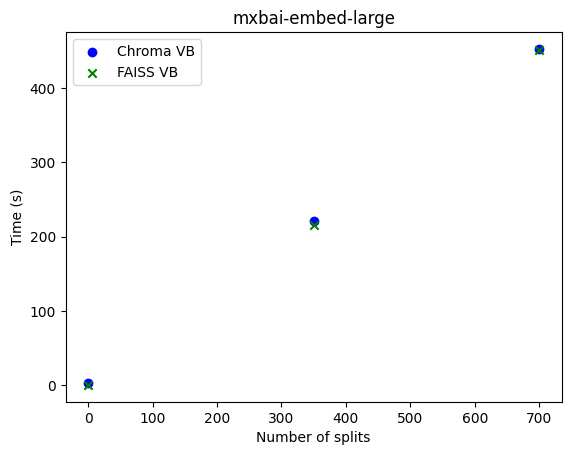

In [16]:
plt.scatter(indices, times1, c='b', marker='o')
plt.scatter(indices, times2, c='g', marker='x')
classes = ['Chroma VB', 'FAISS VB']
plt.title("mxbai-embed-large")
plt.legend(labels=classes)
plt.xlabel("Number of splits")
plt.ylabel("Time (s)")
plt.show()

In [17]:
vb.similarity_search("What is Sage?", k=4)

[Document(metadata={'source': 'sage-website/docs/reference-guides/dev-quick-reference.md'}, page_content='Typical components of a Sage plugin are described below:\n\n1. An application\n\nThis is just your usual Python program, either a single .py script or a set of directories with many components (e.g. ML models, unit tests, test data, etc).\n\n:point_right: First do this step on your machine and perfect it until you are happy with the core functionality.'),
 Document(metadata={'source': 'sage-website/docs/about/overview.md'}, page_content='sidebar_label: Overview sidebar_position: 1\n\nSage: A distributed software-defined sensor network.\n\nWhat is Sage?'),
 Document(metadata={'source': 'sage-data-client/README.md'}, page_content='Sage Data Client\n\nThis is the official Sage Python data API client. Its main goal is to make writing queries and working with the results easy. It does this by:\n\nProviding a simple query function which talks to the data API.\n\nProviding the results in 

In [18]:
vb2.similarity_search("What is Sage?", k=4)

[Document(metadata={}, page_content='Typical components of a Sage plugin are described below:\n\n1. An application\n\nThis is just your usual Python program, either a single .py script or a set of directories with many components (e.g. ML models, unit tests, test data, etc).\n\n:point_right: First do this step on your machine and perfect it until you are happy with the core functionality.'),
 Document(metadata={}, page_content='sidebar_label: Overview sidebar_position: 1\n\nSage: A distributed software-defined sensor network.\n\nWhat is Sage?'),
 Document(metadata={}, page_content='Sage Data Client\n\nThis is the official Sage Python data API client. Its main goal is to make writing queries and working with the results easy. It does this by:\n\nProviding a simple query function which talks to the data API.\n\nProviding the results in an easy to use Pandas data frame.\n\nInstallation\n\nSage Data Client can be installed with pip using:\n\nsh pip3 install sage-data-client'),
 Document(me

In [19]:
vb.delete_collection()
indices, times1, times2, vb, vb2 = plot_embed_speeds(jina)

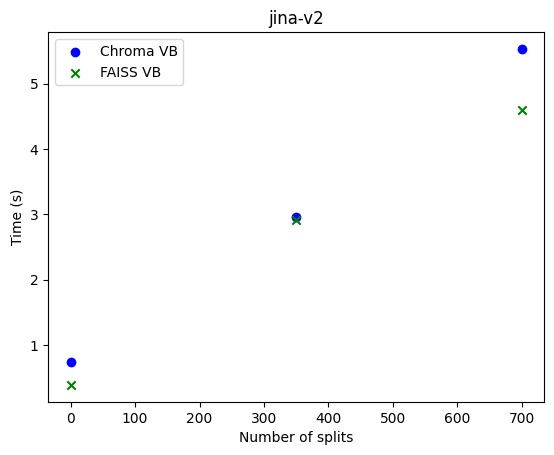

In [20]:
plt.scatter(indices, times1, c='b', marker='o')
plt.scatter(indices, times2, c='g', marker='x')
classes = ['Chroma VB', 'FAISS VB']
plt.title("jina-v2")
plt.legend(labels=classes)
plt.xlabel("Number of splits")
plt.ylabel("Time (s)")
plt.show()

In [21]:
vb.similarity_search("What is Sage?", k=5)

[Document(metadata={'source': 'sage-website/docs/tutorials/accessing-data.md'}, page_content='The Sage data client is a Python library which streamlines querying the data API and getting the results into a Pandas dataframe. For details on installation and usage, please see the Python package.\n\nUsing HTTP API\n\nThis example shows how to retrieve data the latest data from a specific sensor (you can adjust the start field if you do not get any recent data):'),
 Document(metadata={'source': 'sage-data-client/README.md'}, page_content='Sage Data Client\n\nThis is the official Sage Python data API client. Its main goal is to make writing queries and working with the results easy. It does this by:\n\nProviding a simple query function which talks to the data API.\n\nProviding the results in an easy to use Pandas data frame.\n\nInstallation\n\nSage Data Client can be installed with pip using:\n\nsh pip3 install sage-data-client'),
 Document(metadata={'source': 'sage-website/news/2023-10-25-t

In [22]:
vb2.similarity_search("What is Sage?", k=5)

[Document(metadata={}, page_content='The Sage data client is a Python library which streamlines querying the data API and getting the results into a Pandas dataframe. For details on installation and usage, please see the Python package.\n\nUsing HTTP API\n\nThis example shows how to retrieve data the latest data from a specific sensor (you can adjust the start field if you do not get any recent data):'),
 Document(metadata={}, page_content='Sage Data Client\n\nThis is the official Sage Python data API client. Its main goal is to make writing queries and working with the results easy. It does this by:\n\nProviding a simple query function which talks to the data API.\n\nProviding the results in an easy to use Pandas data frame.\n\nInstallation\n\nSage Data Client can be installed with pip using:\n\nsh pip3 install sage-data-client'),
 Document(metadata={}, page_content='The Sage project combines advanced cyberinfrastructure, artificial intelligence (AI), and sensors to create intelligent

In [23]:
vb.similarity_search("Can you provide a simple Waggle plugin that captures an image and publishes the average RGB values?", k=5)

[Document(metadata={'source': 'sage-website/docs/tutorials/edge-apps/2-creating-an-edge-app.md'}, page_content="Now that we have pywaggle, the first change we'll make is to use a camera as input rather than a static image file. We'll use the following shapshot() function to take an RGB snapshot from the camera.\n\n```python import numpy as np\n\nfrom waggle.data.vision import Camera\n\ndef compute_mean_color(image): return np.mean(image, (0, 1)).astype(float)\n\ndef main(): # open camera and take snapshot with Camera() as camera: snapshot = camera.snapshot()"),
 Document(metadata={'source': 'sage-website/docs/tutorials/edge-apps/2-creating-an-edge-app.md'}, page_content='from waggle.plugin import Plugin from waggle.data.vision import Camera\n\ndef compute_mean_color(image): return np.mean(image, (0, 1)).astype(float)\n\ndef main(): with Plugin() as plugin: # open camera and take snapshot with Camera() as camera: snapshot = camera.snapshot()\n\n    # compute mean color\n    mean_color =

In [24]:
vb2.similarity_search("Can you provide a simple Waggle plugin that captures an image and publishes the average RGB values?", k=5)

[Document(metadata={}, page_content="Now that we have pywaggle, the first change we'll make is to use a camera as input rather than a static image file. We'll use the following shapshot() function to take an RGB snapshot from the camera.\n\n```python import numpy as np\n\nfrom waggle.data.vision import Camera\n\ndef compute_mean_color(image): return np.mean(image, (0, 1)).astype(float)\n\ndef main(): # open camera and take snapshot with Camera() as camera: snapshot = camera.snapshot()"),
 Document(metadata={}, page_content='from waggle.plugin import Plugin from waggle.data.vision import Camera\n\ndef compute_mean_color(image): return np.mean(image, (0, 1)).astype(float)\n\ndef main(): with Plugin() as plugin: # open camera and take snapshot with Camera() as camera: snapshot = camera.snapshot()\n\n    # compute mean color\n    mean_color = compute_mean_color(snapshot.data)'),
 Document(metadata={}, page_content='from waggle.plugin import Plugin from waggle.data.vision import Camera\n\nd

## So far it seems that there's no accuracy difference between embed model and VB 

In [25]:
k_vals = [1, 6, 12]

In [26]:
all_code_times = generation_speed(vb, code_questions, k_vals)

In [27]:
all_text_times = generation_speed(vb, text_questions, k_vals)

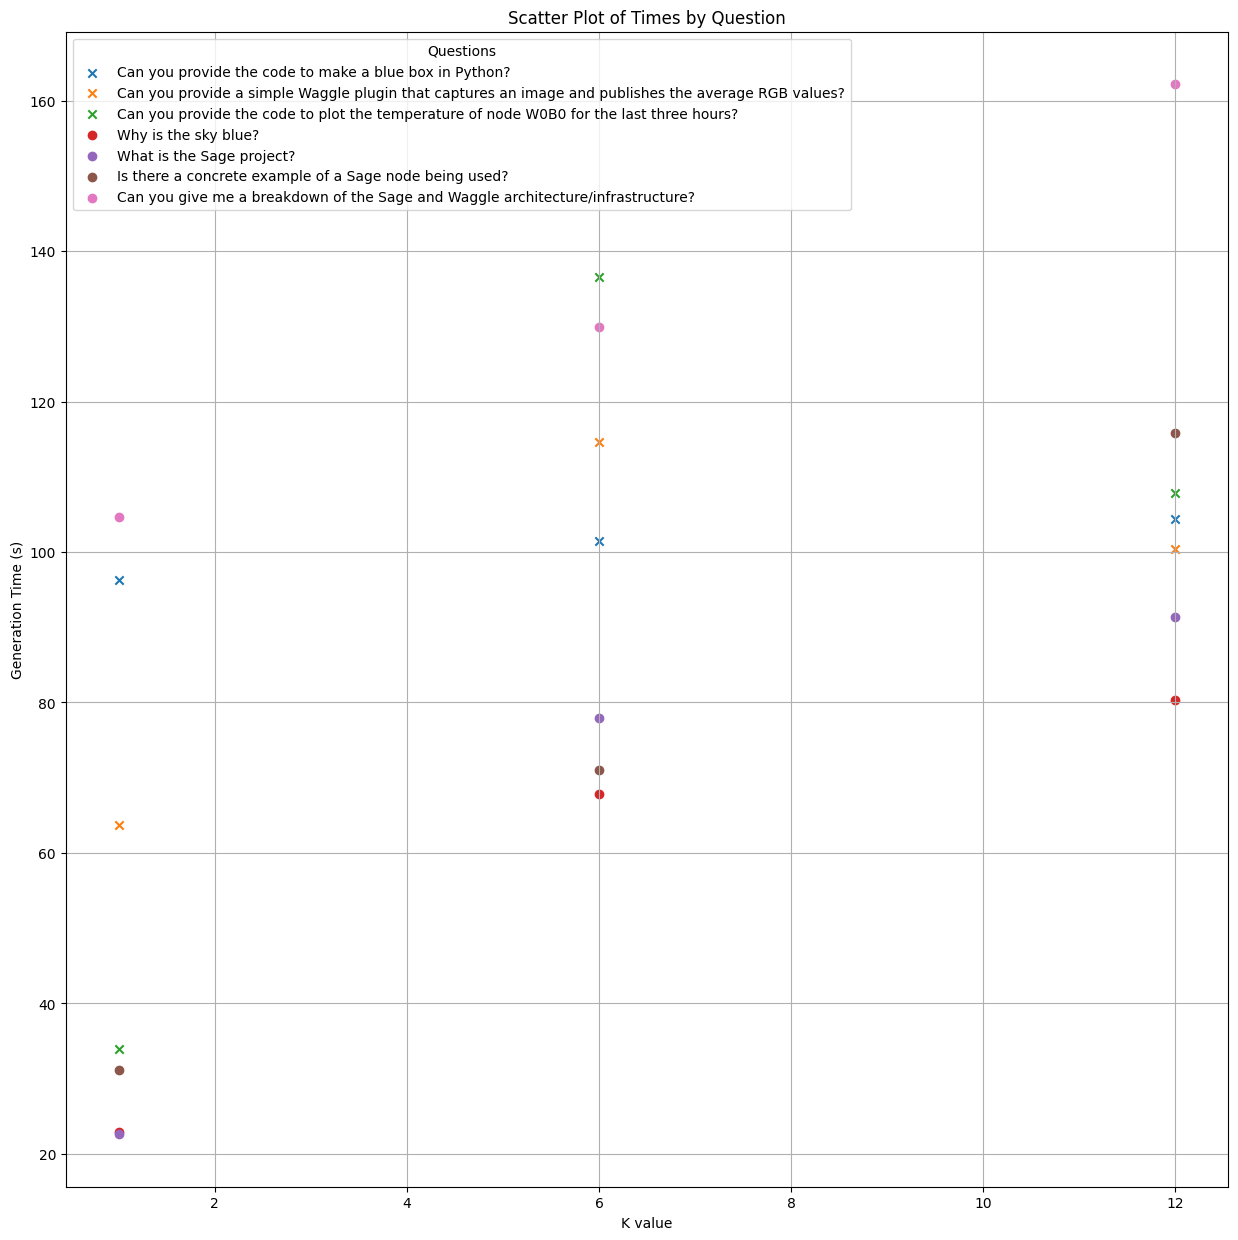

In [30]:
# Create a scatter plot
plt.figure(figsize=(15, 15))

# Loop through each question and corresponding times
for i, question in enumerate(code_questions):
    plt.scatter(k_vals, all_code_times[i], label=question, marker='x')

for i, question in enumerate(text_questions):
    plt.scatter(k_vals, all_text_times[i], label=question, marker='o')

# Add titles and labels
plt.title("Scatter Plot of Times by Question")
plt.xlabel("K value")
plt.ylabel("Generation Time (s)")
plt.legend(title="Questions")
plt.grid(True)

# Show the plot
plt.show()